In [11]:
# Import functions from our geogfm module
from geogfm.c01 import (
    verify_environment,
    setup_planetary_computer_auth,
    search_sentinel2_scenes,
    load_sentinel2_bands
)

# Core libraries
import warnings
import numpy as np
import pandas as pd
import xarray as xr
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.merge import merge
import rioxarray
from pathlib import Path
from datetime import datetime, timedelta
from pystac_client import Client
import folium
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor
from functools import partial
#import dask
#from dask.distributed import Client as DaskClient
from typing import Dict, List, Tuple, Optional, Union

warnings.filterwarnings('ignore')

# Verify environment using our standardized function
required_packages = [
    'numpy', 'pandas', 'xarray', 'rasterio', 'rioxarray',
    'pystac_client', 'folium', 'matplotlib', 'dask'
]
env_status = verify_environment(required_packages)

# Set up study area - Santa Barbara, California (coastal urban/natural interface)
santa_barbara_bbox = [-116.663856, 32.630781, -115.9515018, 33.33956] # [west, south, east, north]

# Define longer time range for trend analysis
start_date = "2017-02-01"
end_date = "2017-04-01"
max_cloud_cover = 25  # More restrictive for cleaner mosaics

print(f"Study Area: AB, California")
print(f"Time Range: {start_date} to {end_date}")
print(f"Max Cloud Cover: {max_cloud_cover}%")

2025-10-16 21:46:23,430 - INFO - ✅ All 9 packages verified


Study Area: AB, California
Time Range: 2017-02-01 to 2017-04-01
Max Cloud Cover: 25%


In [2]:
# ImportError: cannot import name 'apply' from 'dask.compatibility' (/home/g288kc/miniforge/envs/geoAI/lib/python3.11/site-packages/dask/compatibility.py)

In [13]:
# Set up authentication using our standardized function
auth_status = setup_planetary_computer_auth()

# Search for scenes using our enhanced search function
print("Searching for multiple Sentinel-2 scenes...")
items = search_sentinel2_scenes(
    bbox=santa_barbara_bbox,
    date_range=f"{start_date}/{end_date}",
    cloud_cover_max=max_cloud_cover,
    limit=50
)

print(f"Found {len(items)} scenes")

# Organize scenes by date and tile
scene_info = []
for item in items:
    props = item.properties
    date = props['datetime'].split('T')[0]
    tile_id = item.id.split('_')[5]  # Extract tile ID from scene name
    cloud_cover = props.get('eo:cloud_cover', 0)

    scene_info.append({
        'id': item.id,
        'date': date,
        'tile': tile_id,
        'cloud_cover': cloud_cover,
        'item': item
    })

# Convert to DataFrame for easier analysis
scenes_df = pd.DataFrame(scene_info)
print(f"\nScene Distribution:")
print(f"  Unique dates: {scenes_df['date'].nunique()}")
print(f"  Unique tiles: {scenes_df['tile'].nunique()}")
print(f"  Date range: {scenes_df['date'].min()} to {scenes_df['date'].max()}")

# Show scenes by tile
print(f"\nScenes by Tile:")
tile_counts = scenes_df.groupby('tile').size().sort_values(ascending=False)
for tile, count in tile_counts.head().items():
    avg_cloud = scenes_df[scenes_df['tile'] == tile]['cloud_cover'].mean()
    print(f"  {tile}: {count} scenes (avg cloud: {avg_cloud:.1f}%)")

2025-10-16 21:46:35,018 - INFO - Using anonymous access (basic rate limits)


Searching for multiple Sentinel-2 scenes...


2025-10-16 21:46:36,065 - INFO - Found 5 Sentinel-2 scenes (cloud cover < 25%)


Found 5 scenes

Scene Distribution:
  Unique dates: 5
  Unique tiles: 5
  Date range: 2017-02-13 to 2017-04-01

Scenes by Tile:
  20210208T120143: 1 scenes (avg cloud: 1.8%)
  20210208T162405: 1 scenes (avg cloud: 17.0%)
  20210208T215440: 1 scenes (avg cloud: 2.1%)
  20210209T014017: 1 scenes (avg cloud: 21.2%)
  20210209T034858: 1 scenes (avg cloud: 0.9%)


In [14]:
# Create map showing all scene footprints
m = folium.Map(
    location=[33.300846, -116.327950],  # Center of henderson wildflower viewing area
    zoom_start=10,
    tiles='OpenStreetMap'
)

# Add study area boundary
folium.Rectangle(
    bounds=[[santa_barbara_bbox[1], santa_barbara_bbox[0]],
            [santa_barbara_bbox[3], santa_barbara_bbox[2]]],
    color='red',
    fill=False,
    weight=3,
    popup="Study Area: Santa Barbara"
).add_to(m)

# Add scene footprints colored by date
colors = ['blue', 'green', 'orange', 'purple', 'red']
unique_dates = sorted(scenes_df['date'].unique())

for i, date in enumerate(unique_dates[:5]):  # Show first 5 dates
    date_scenes = scenes_df[scenes_df['date'] == date]
    color = colors[i % len(colors)]

    for _, scene in date_scenes.iterrows():
        item = scene['item']
        geom = item.geometry

        # Add scene footprint
        folium.GeoJson(
            geom,
            style_function=lambda x, color=color: {
                'fillColor': color,
                'color': color,
                'weight': 2,
                'fillOpacity': 0.3
            },
            popup=f"Date: {date}<br>Tile: {scene['tile']}<br>Cloud: {scene['cloud_cover']:.1f}%"
        ).add_to(m)

folium.LayerControl().add_to(m)
print("Scene coverage map created")
m

Scene coverage map created


In [15]:
# SCL class definitions (Sentinel-2 Level 2A)
scl_classes = {
    0: "No Data",
    1: "Saturated or defective",
    2: "Dark area pixels",
    3: "Cloud shadows",
    4: "Vegetation",
    5: "Not vegetated",
    6: "Water",
    7: "Unclassified",
    8: "Cloud medium probability",
    9: "Cloud high probability",
    10: "Thin cirrus",
    11: "Snow"
}

# Define what we consider "good" pixels for analysis
good_pixel_classes = [4, 5, 6]  # Vegetation, not vegetated, water
cloud_classes = [3, 8, 9, 10]   # Cloud shadows, clouds, cirrus

print("Scene Classification Layer (SCL) Classes:")
for class_id, description in scl_classes.items():
    marker = "✓" if class_id in good_pixel_classes else "✗" if class_id in cloud_classes else "·"
    print(f"  {marker} {class_id}: {description}")

print(f"\nGood pixels for analysis: {good_pixel_classes}")
print(f"Cloud/shadow pixels to mask: {cloud_classes}")

Scene Classification Layer (SCL) Classes:
  · 0: No Data
  · 1: Saturated or defective
  · 2: Dark area pixels
  ✗ 3: Cloud shadows
  ✓ 4: Vegetation
  ✓ 5: Not vegetated
  ✓ 6: Water
  · 7: Unclassified
  ✗ 8: Cloud medium probability
  ✗ 9: Cloud high probability
  ✗ 10: Thin cirrus
  · 11: Snow

Good pixels for analysis: [4, 5, 6]
Cloud/shadow pixels to mask: [3, 8, 9, 10]


In [16]:
"""Week 2: Advanced preprocessing functions for Sentinel-2 data."""

import logging
import numpy as np
import pandas as pd
import xarray as xr
from typing import Dict, List, Tuple, Optional, Union
from pathlib import Path
from functools import partial
from concurrent.futures import ThreadPoolExecutor
from geogfm.c01 import load_sentinel2_bands, setup_planetary_computer_auth, search_sentinel2_scenes

# Configure logger for minimal output
logger = logging.getLogger(__name__)

In [17]:
def create_cloud_mask(scl_data, good_classes: List[int]) -> np.ndarray:
    """
    Create binary cloud mask from Scene Classification Layer.

    Educational note: np.isin checks if each pixel value is in our 'good' list.
    Returns True for clear pixels, False for clouds/shadows.

    Args:
        scl_data: Scene Classification Layer data (numpy array or xarray DataArray)
        good_classes: List of SCL values considered valid pixels

    Returns:
        Binary mask array (True for valid pixels)
    """
    # Handle both numpy arrays and xarray DataArrays
    if hasattr(scl_data, 'values'):
        scl_values = scl_data.values
    else:
        scl_values = scl_data

    return np.isin(scl_values, good_classes)

In [18]:
def apply_cloud_mask(band_data: Dict[str, Union[np.ndarray, xr.DataArray]],
                     scl_data: Union[np.ndarray, xr.DataArray],
                     good_pixel_classes: List[int],
                     target_resolution: int = 20) -> Tuple[Dict[str, xr.DataArray], float]:
    """
    Apply SCL-based cloud masking to spectral bands.

    Args:
        band_data: Dictionary of band DataArrays
        scl_data: Scene Classification Layer DataArray
        good_pixel_classes: List of SCL values considered valid
        target_resolution: Target resolution for resampling bands

    Returns:
        masked_data: Dictionary with masked bands
        valid_pixel_fraction: Fraction of valid pixels
    """
    from scipy.ndimage import zoom

    # Get SCL data and ensure it's at target resolution
    scl_array = scl_data
    if hasattr(scl_data, 'values'):
        scl_values = scl_data.values
    else:
        scl_values = scl_data

    # Create cloud mask from SCL
    good_pixels = create_cloud_mask(scl_data, good_pixel_classes)

    # Get target shape from SCL (typically 20m resolution)
    target_shape = scl_values.shape

    # Apply mask to spectral bands
    masked_data = {}
    # Map Sentinel-2 bands to readable names
    band_mapping = {'B04': 'red', 'B03': 'green', 'B02': 'blue', 'B08': 'nir'}

    for band_name in ['B04', 'B03', 'B02', 'B08']:
        if band_name in band_data:
            band_array = band_data[band_name]

            # Get band values (handle both numpy arrays and xarray DataArrays)
            if hasattr(band_array, 'values'):
                band_values = band_array.values
            else:
                band_values = band_array

            # Resample band to match SCL resolution if needed
            if band_values.shape != target_shape:
                # Calculate zoom factors for each dimension
                zoom_factors = (
                    target_shape[0] / band_values.shape[0],
                    target_shape[1] / band_values.shape[1]
                )

                # Use scipy zoom for robust resampling
                try:
                    band_values = zoom(band_values, zoom_factors, order=1)
                    logger.debug(f"Resampled {band_name} from {band_values.shape} to {target_shape}")
                except Exception as e:
                    logger.warning(f"Failed to resample {band_name}: {e}")
                    continue

            # Ensure shapes match after resampling
            if band_values.shape != target_shape:
                logger.warning(f"Shape mismatch for {band_name}: {band_values.shape} vs {target_shape}")
                continue

            # Mask invalid pixels with NaN
            masked_values = np.where(good_pixels, band_values, np.nan)

            # Use meaningful band names (red, green, blue, nir)
            readable_name = band_mapping[band_name]

            # Create DataArray with coordinates if available
            if hasattr(scl_array, 'coords') and hasattr(scl_array, 'dims'):
                masked_data[readable_name] = xr.DataArray(
                    masked_values,
                    coords=scl_array.coords,
                    dims=scl_array.dims
                )
            else:
                # Create with named dimensions for better compatibility
                dims = ['y', 'x'] if len(masked_values.shape) == 2 else ['dim_0', 'dim_1']
                masked_data[readable_name] = xr.DataArray(
                    masked_values,
                    dims=dims
                )

    # Calculate valid pixel fraction
    valid_pixel_fraction = np.sum(good_pixels) / good_pixels.size

    # Store SCL and mask for reference
    if hasattr(scl_data, 'coords') and hasattr(scl_data, 'dims'):
        masked_data['scl'] = scl_data
        masked_data['cloud_mask'] = xr.DataArray(
            good_pixels,
            coords=scl_data.coords,
            dims=scl_data.dims
        )
    else:
        # Create with named dimensions for consistency
        dims = ['y', 'x'] if len(good_pixels.shape) == 2 else ['dim_0', 'dim_1']
        masked_data['scl'] = xr.DataArray(scl_data, dims=dims)
        masked_data['cloud_mask'] = xr.DataArray(good_pixels, dims=dims)

    return masked_data, valid_pixel_fraction

In [19]:
def load_scene_with_cloudmask(item, target_crs: str = 'EPSG:32611',
                              target_resolution: int = 20,
                              good_pixel_classes: List[int] = [4, 5, 6],
                              subset_bbox: Optional[List[float]] = None) -> Tuple[Optional[Dict[str, xr.DataArray]], float]:
    """
    Load a Sentinel-2 scene with cloud masking applied using geogfm functions.

    Args:
        item: STAC item
        target_crs: Target coordinate reference system
        target_resolution: Target pixel size in meters
        good_pixel_classes: List of SCL values considered valid
        subset_bbox: Optional spatial subset as [west, south, east, north] in WGS84

    Returns:
        masked_data: dict with masked bands
        valid_pixel_fraction: fraction of valid pixels
    """
    try:
        # Use the tested function from geogfm.c01
        band_data = load_sentinel2_bands(
            item,
            bands=['B04', 'B03', 'B02', 'B08', 'SCL'],
            subset_bbox=subset_bbox,
            max_retries=3
        )

        if not band_data or 'SCL' not in band_data:
            logger.warning(f"No data or missing SCL for scene {item.id}")
            return None, 0

        # Apply cloud masking using SCL with target resolution
        masked_data, valid_fraction = apply_cloud_mask(
            band_data, band_data['SCL'], good_pixel_classes, target_resolution
        )

        return masked_data, valid_fraction

    except Exception as e:
        logger.error(f"Error loading scene {item.id}: {str(e)}")
        return None, 0

In [20]:
def process_single_scene(item, target_crs: str = 'EPSG:32611',
                         target_resolution: int = 20,
                         min_valid_fraction: float = 0.3,
                         good_pixel_classes: List[int] = [4, 5, 6],
                         subset_bbox: Optional[List[float]] = None) -> Optional[Dict]:
    """
    Process a single scene with validation.

    Args:
        item: STAC item
        target_crs: Target coordinate reference system
        target_resolution: Target pixel size in meters
        min_valid_fraction: Minimum fraction of valid pixels required
        good_pixel_classes: List of SCL values considered valid
        subset_bbox: Optional spatial subset as [west, south, east, north] in WGS84

    Returns:
        Scene data dictionary or None if invalid
    """
    data, valid_frac = load_scene_with_cloudmask(
        item, target_crs=target_crs, target_resolution=target_resolution,
        good_pixel_classes=good_pixel_classes, subset_bbox=subset_bbox
    )

    if data and valid_frac > min_valid_fraction:
        return {
            'id': item.id,
            'date': item.properties['datetime'].split('T')[0],
            'data': data,
            'valid_fraction': valid_frac,
            'item': item
        }
    else:
        logger.info(f"Skipped {item.id[:30]} (valid fraction: {valid_frac:.1%})")
        return None

In [21]:
def process_scene_batch(scene_items: List, max_workers: int = 4,
                        target_crs: str = 'EPSG:32611',
                        target_resolution: int = 20,
                        min_valid_fraction: float = 0.3,
                        good_pixel_classes: List[int] = [4, 5, 6],
                        subset_bbox: Optional[List[float]] = None) -> List[Dict]:
    """
    Process multiple scenes in parallel with cloud masking and reprojection.

    Args:
        scene_items: List of STAC items
        max_workers: Number of parallel workers
        target_crs: Target coordinate reference system
        target_resolution: Target resolution in meters
        min_valid_fraction: Minimum valid pixel fraction
        good_pixel_classes: List of SCL values considered valid
        subset_bbox: Optional spatial subset

    Returns:
        processed_scenes: List of processed scene data
    """
    logger.info(f"Processing {len(scene_items)} scenes with {max_workers} workers")

    # Use partial to pass additional parameters
    process_func = partial(
        process_single_scene,
        target_crs=target_crs,
        target_resolution=target_resolution,
        min_valid_fraction=min_valid_fraction,
        good_pixel_classes=good_pixel_classes,
        subset_bbox=subset_bbox
    )

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        results = list(executor.map(process_func, scene_items))

    # Filter successful results
    processed_scenes = [result for result in results if result is not None]

    logger.info(f"Successfully processed {len(processed_scenes)} scenes")
    return processed_scenes

In [22]:
def create_temporal_mosaic(processed_scenes, method: str = 'median'):
    """
    Create a temporal mosaic from multiple processed scenes.

    Args:
        processed_scenes: List of processed scene dictionaries
        method: Compositing method ('median', 'mean', 'max')

    Returns:
        mosaic_data: Temporal composite as xarray Dataset
    """
    if not processed_scenes:
        logger.warning("No scenes to mosaic")
        return None

    # Group data by band
    bands = ['red', 'green', 'blue', 'nir']
    band_stacks = {}
    dates = []

    # Find minimum common shape across all scenes
    min_shape = None
    for scene in processed_scenes:
        scene_shape = scene['data']['red'].shape
        if min_shape is None:
            min_shape = scene_shape
        else:
            min_shape = tuple(min(a, b) for a, b in zip(min_shape, scene_shape))

    for band in bands:
        band_data = []
        for scene in processed_scenes:
            # Trim to common shape to handle slight size mismatches
            band_array = scene['data'][band]
            if band_array.shape != min_shape:
                band_array = band_array[:min_shape[0], :min_shape[1]]
            band_data.append(band_array)
            if band == 'red':  # Only collect dates once
                dates.append(scene['date'])

        # Stack along time dimension
        band_stack = xr.concat(band_data, dim='time')
        band_stack = band_stack.assign_coords(time=dates)

        # Apply temporal compositing
        if method == 'median':
            band_stacks[band] = band_stack.median(dim='time', skipna=True)
        elif method == 'mean':
            band_stacks[band] = band_stack.mean(dim='time', skipna=True)
        elif method == 'max':
            band_stacks[band] = band_stack.max(dim='time', skipna=True)

    # Create mosaic dataset
    mosaic_data = xr.Dataset(band_stacks)

    # Add metadata
    mosaic_data.attrs['method'] = method
    mosaic_data.attrs['n_scenes'] = len(processed_scenes)
    mosaic_data.attrs['date_range'] = f"{min(dates)} to {max(dates)}"

    logger.info(f"Mosaic created from {len(processed_scenes)} scenes using {method}")
    return mosaic_data

In [23]:
def build_temporal_datacube(processed_scenes, chunk_size='auto'):
    """
    Build an analysis-ready temporal data cube.

    Args:
        processed_scenes: List of processed scenes
        chunk_size: Dask chunk size for memory management

    Returns:
        datacube: xarray Dataset with time dimension
    """
    if not processed_scenes:
        return None

    # Sort scenes by date
    processed_scenes.sort(key=lambda x: x['date'])

    # Extract dates and data
    dates = [pd.to_datetime(scene['date']) for scene in processed_scenes]
    bands = ['red', 'green', 'blue', 'nir']

    # Find minimum common shape across all scenes
    min_shape = None
    for scene in processed_scenes:
        scene_shape = scene['data']['red'].shape
        if min_shape is None:
            min_shape = scene_shape
        else:
            min_shape = tuple(min(a, b) for a, b in zip(min_shape, scene_shape))

    # Build data arrays for each band
    band_cubes = {}

    for band in bands:
        # Stack all scenes for this band
        band_data = []
        for scene in processed_scenes:
            # Trim to common shape to handle slight size mismatches
            band_array = scene['data'][band]
            if band_array.shape != min_shape:
                band_array = band_array[:min_shape[0], :min_shape[1]]
            band_data.append(band_array)

        # Create temporal stack
        band_cube = xr.concat(band_data, dim='time')
        band_cube = band_cube.assign_coords(time=dates)

        # Add chunking for large datasets
        if chunk_size == 'auto':
            # Get actual dimension names from the data
            dims = band_cube.dims
            if len(dims) == 3:  # time, dim_0, dim_1 or time, y, x
                chunks = {dims[0]: 1, dims[1]: 512, dims[2]: 512}
            else:
                chunks = {}
        else:
            chunks = chunk_size

        # Only apply chunking if chunks are specified
        if chunks:
            band_cubes[band] = band_cube.chunk(chunks)
        else:
            band_cubes[band] = band_cube

    # Create dataset
    datacube = xr.Dataset(band_cubes)

    # Add derived indices
    datacube['ndvi'] = ((datacube['nir'] - datacube['red']) /
                        (datacube['nir'] + datacube['red'] + 1e-8))

    # Enhanced Vegetation Index (EVI)
    datacube['evi'] = (2.5 * (datacube['nir'] - datacube['red']) /
                       (datacube['nir'] + 6 * datacube['red'] - 7.5 * datacube['blue'] + 1))

    # Add metadata
    datacube.attrs.update({
        'title': 'Sentinel-2 Analysis-Ready Data Cube',
        'description': 'Cloud-masked, reprojected temporal stack',
        'n_scenes': len(processed_scenes),
        'time_range': f"{dates[0].strftime('%Y-%m-%d')} to {dates[-1].strftime('%Y-%m-%d')}",
        'crs': str(datacube['red'].rio.crs) if hasattr(datacube['red'], 'rio') and datacube['red'].rio.crs else 'Unknown',
        'resolution': 'Variable (depends on original scene resolution)'
    })

    logger.info(f"Data cube created: {datacube['red'].shape}, {len(dates)} time steps")
    return datacube

In [24]:
class Sentinel2Preprocessor:
    """
    Scalable Sentinel-2 preprocessing pipeline using geogfm functions.
    """

    def __init__(self, output_dir: str = "preprocessed_data", target_crs: str = 'EPSG:32611',
                 target_resolution: int = 20, max_cloud_cover: float = 15,
                 good_pixel_classes: List[int] = [4, 5, 6]):
        self.output_dir = Path(output_dir)
        self.output_dir.mkdir(exist_ok=True)
        self.target_crs = target_crs
        self.target_resolution = target_resolution
        self.max_cloud_cover = max_cloud_cover
        self.good_pixel_classes = good_pixel_classes

        # Set up authentication once during initialization
        setup_planetary_computer_auth()

    def search_scenes(self, bbox: List[float], start_date: str, end_date: str,
                      limit: int = 100) -> List:
        """Search for Sentinel-2 scenes using geogfm standardized function."""
        # Ensure authentication is set up
        setup_planetary_computer_auth()

        # Use our standardized search function
        date_range = f"{start_date}/{end_date}"
        items = search_sentinel2_scenes(
            bbox=bbox,
            date_range=date_range,
            cloud_cover_max=self.max_cloud_cover,
            limit=limit
        )

        logger.info(f"Found {len(items)} scenes")
        return items

    def process_scene(self, item, save_individual: bool = True, subset_bbox: Optional[List[float]] = None) -> Optional[Dict]:
        """Process a single scene with cloud masking using geogfm functions."""
        scene_id = item.id
        output_path = self.output_dir / f"{scene_id}_processed.nc"

        # Skip if already processed
        if output_path.exists():
            if save_individual:
                return str(output_path)
            else:
                # Load existing data for in-memory processing
                return xr.open_dataset(output_path)

        # Process scene using our enhanced function
        data, valid_frac = load_scene_with_cloudmask(
            item, self.target_crs, self.target_resolution, self.good_pixel_classes, subset_bbox
        )

        if data and valid_frac > 0.3:
            if save_individual:
                try:
                    # Convert to xarray Dataset
                    scene_ds = xr.Dataset(data)
                    scene_ds.attrs.update({
                        'scene_id': scene_id,
                        'date': item.properties['datetime'].split('T')[0],
                        'cloud_cover': item.properties.get('eo:cloud_cover', 0),
                        'valid_pixel_fraction': valid_frac,
                        'processing_crs': self.target_crs,
                        'processing_resolution': self.target_resolution
                    })

                    # Save to NetCDF using scipy engine (no netcdf4 required)
                    scene_ds.to_netcdf(output_path, engine='scipy')
                except Exception as e:
                    logger.error(f"Save error for {scene_id}: {str(e)[:50]}")

            return data
        else:
            logger.info(f"Skipped {scene_id} (valid fraction: {valid_frac:.1%})")
            return None

    def create_time_series_cube(self, processed_data_list, cube_name: str = "datacube"):
        """Create and save temporal data cube."""
        if not processed_data_list:
            logger.warning("No data to create cube")
            return None

        cube_path = self.output_dir / f"{cube_name}.nc"

        # Build temporal stack
        dates = []
        band_stacks = {band: [] for band in ['red', 'green', 'blue', 'nir']}

        for data in processed_data_list:
            if data:
                # Handle dictionary format, string file path, or xarray Dataset
                if isinstance(data, dict):
                    # Dictionary format from fresh processing
                    for band in band_stacks.keys():
                        if band in data:
                            band_stacks[band].append(data[band])
                elif isinstance(data, str):
                    # File path - load the file first
                    loaded_ds = xr.open_dataset(data)
                    for band in band_stacks.keys():
                        if band in loaded_ds.data_vars:
                            band_data = loaded_ds[band]
                            if 'time' in band_data.dims and band_data.dims['time'] > 1:
                                band_data = band_data.isel(time=0)
                            elif 'time' in band_data.dims:
                                band_data = band_data.squeeze('time')
                            band_stacks[band].append(band_data)
                else:
                    # xarray Dataset from loaded file - extract individual bands
                    for band in band_stacks.keys():
                        if band in data.data_vars:
                            # If the loaded data has a time dimension, select the first time slice
                            band_data = data[band]
                            if 'time' in band_data.dims and band_data.dims['time'] > 1:
                                # Multiple time slices in saved file - take first one
                                band_data = band_data.isel(time=0)
                            elif 'time' in band_data.dims:
                                # Single time slice - remove time dimension
                                band_data = band_data.squeeze('time')

                            band_stacks[band].append(band_data)

        # Create dataset
        cube_data = {}

        for band, stack in band_stacks.items():
            if stack:
                # Check that all scenes have this band
                if len(stack) == len(processed_data_list):
                    try:
                        cube_data[band] = xr.concat(stack, dim='time')
                    except Exception as e:
                        logger.error(f"Failed to concatenate {band}: {e}")
                else:
                    logger.warning(f"{band} missing from some scenes ({len(stack)}/{len(processed_data_list)})")

        if cube_data:
            try:
                datacube = xr.Dataset(cube_data)
            except Exception as e:
                logger.error(f"Failed to create dataset: {e}")
                return None

            # Add vegetation indices
            datacube['ndvi'] = ((datacube['nir'] - datacube['red']) /
                                (datacube['nir'] + datacube['red'] + 1e-8))

            # Save cube using scipy engine (no netcdf4 required)
            try:
                datacube.to_netcdf(cube_path, engine='scipy')
            except Exception:
                zarr_path = cube_path.with_suffix('.zarr')
                datacube.to_zarr(zarr_path)

            logger.info(f"Data cube saved: {cube_path}")
            return datacube

        return None

In [ ]:
# Define a useful subset for demonstration
santa_barbara_coastal = [-116.3, 32.33, -115.9515018, 33.33956]  # ~20km × 15km coastal area

print(f"Using subset: {santa_barbara_coastal}")

In [ ]:
# Test with one scene
test_item = scenes_df.iloc[0]['item']
print(f"Testing cloud masking with scene: {test_item.id}")

# Define good pixel classes for this demonstration
good_pixel_classes = [4, 5, 6]  # Vegetation, not vegetated, water

# Test our enhanced cloud masking function with spatial subset
masked_data, valid_fraction = load_scene_with_cloudmask(
    test_item,
    target_crs='EPSG:32611',  # UTM Zone 11N for Santa Barbara
    target_resolution=20,  # Resample to 20m to match SCL
    good_pixel_classes=good_pixel_classes,
    subset_bbox=santa_barbara_coastal  # Use subset for faster processing
)

if masked_data:
    print(f"Scene loaded successfully")
    print(f"Data shape: {masked_data['red'].shape}")
    print(f"Valid pixels: {valid_fraction:.1%}")
    print(f"Cloudy pixels: {1-valid_fraction:.1%}")
else:
    print("Failed to load scene")

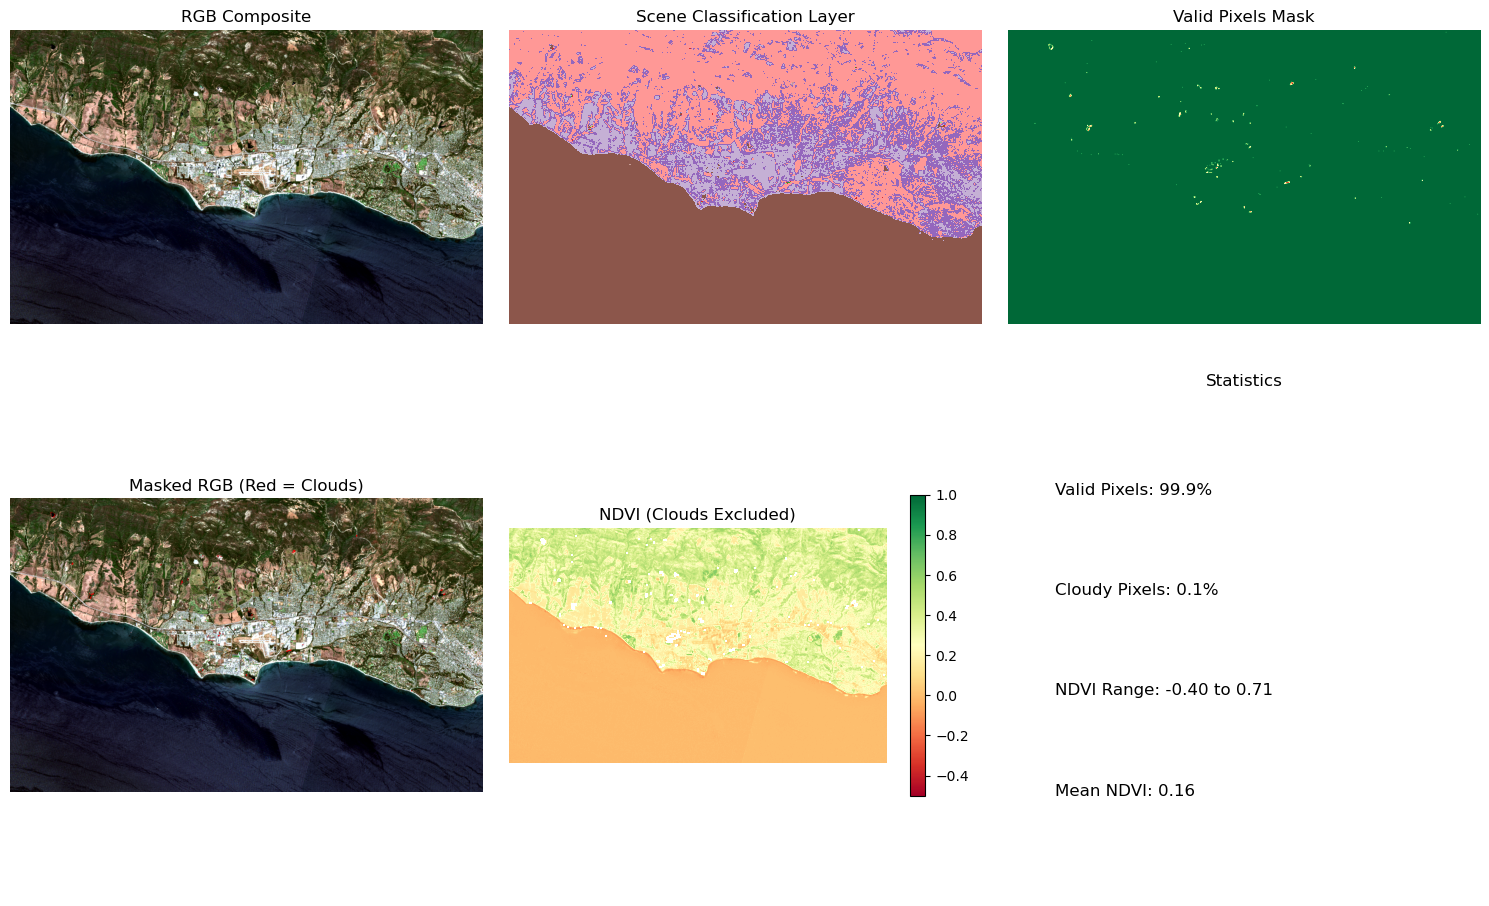

Cloud masking visualization complete


In [18]:
if masked_data:
    # Create visualization of cloud masking
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    # Original RGB (before masking)
    red_orig = masked_data['red'].fillna(0)  # Fill NaN for display
    green_orig = masked_data['green'].fillna(0)
    blue_orig = masked_data['blue'].fillna(0)

    # Normalize for RGB display
    def normalize_for_display(band, percentiles=(2, 98)):
        valid_data = band[~np.isnan(band)]
        if len(valid_data) > 0:
            p_low, p_high = np.percentile(valid_data, percentiles)
            return np.clip((band - p_low) / (p_high - p_low), 0, 1)
        return band

    red_norm = normalize_for_display(red_orig.values)
    green_norm = normalize_for_display(green_orig.values)
    blue_norm = normalize_for_display(blue_orig.values)

    rgb_composite = np.dstack([red_norm, green_norm, blue_norm])

    # Plot results
    axes[0,0].imshow(rgb_composite)
    axes[0,0].set_title('RGB Composite')
    axes[0,0].axis('off')

    # Scene Classification Layer
    scl_plot = axes[0,1].imshow(masked_data['scl'].values, cmap='tab20', vmin=0, vmax=11)
    axes[0,1].set_title('Scene Classification Layer')
    axes[0,1].axis('off')

    # Cloud mask
    axes[0,2].imshow(masked_data['cloud_mask'].values, cmap='RdYlGn', vmin=0, vmax=1)
    axes[0,2].set_title('Valid Pixels Mask')
    axes[0,2].axis('off')

    # Masked RGB
    masked_rgb = rgb_composite.copy()
    masked_rgb[~masked_data['cloud_mask'].values] = [1, 0, 0]  # Red for masked areas
    axes[1,0].imshow(masked_rgb)
    axes[1,0].set_title('Masked RGB (Red = Clouds)')
    axes[1,0].axis('off')

    # NDVI calculation on masked data
    # The Normalized Difference Vegetation Index (NDVI) is calculated as:
    # NDVI = (NIR - Red) / (NIR + Red)
    nir_masked = masked_data['nir'].values
    red_masked = masked_data['red'].values
    ndvi = (nir_masked - red_masked) / (nir_masked + red_masked + 1e-8)

    ndvi_plot = axes[1,1].imshow(ndvi, cmap='RdYlGn', vmin=-0.5, vmax=1.0)
    axes[1,1].set_title('NDVI (Clouds Excluded)')
    axes[1,1].axis('off')
    plt.colorbar(ndvi_plot, ax=axes[1,1], shrink=0.6)

    # Statistics
    axes[1,2].text(0.1, 0.8, f"Valid Pixels: {valid_fraction:.1%}", transform=axes[1,2].transAxes, fontsize=12)
    axes[1,2].text(0.1, 0.6, f"Cloudy Pixels: {1-valid_fraction:.1%}", transform=axes[1,2].transAxes, fontsize=12)
    axes[1,2].text(0.1, 0.4, f"NDVI Range: {np.nanmin(ndvi):.2f} to {np.nanmax(ndvi):.2f}", transform=axes[1,2].transAxes, fontsize=12)
    axes[1,2].text(0.1, 0.2, f"Mean NDVI: {np.nanmean(ndvi):.2f}", transform=axes[1,2].transAxes, fontsize=12)
    axes[1,2].set_title('Statistics')
    axes[1,2].axis('off')

    plt.tight_layout()
    plt.show()

    print("Cloud masking visualization complete")

In [19]:
# Select subset of scenes for processing (to manage computational load)
selected_scenes = scenes_df.head(3)['item'].tolist()  # Process 3 scenes for fast demo

# Use even smaller spatial subset for faster demonstration
# This tiny area (~5km × 5km) processes in seconds instead of minutes
fast_subset = [-119.85, 34.40, -119.80, 34.45]  # Tiny subset near UCSB

print(f"Processing {len(selected_scenes)} scenes with small spatial subset for speed")
print(f"Subset area: ~5km × 5km around UCSB campus")

processed_scenes = process_scene_batch(
    selected_scenes,
    max_workers=2,
    min_valid_fraction=0.1,  # Lower threshold to include more scenes
    subset_bbox=fast_subset
)

# Show processing results
if processed_scenes:
    print(f"\nProcessing Summary:")
    for scene in processed_scenes:
        print(f"  {scene['date']}: {scene['valid_fraction']:.1%} valid pixels")

2025-10-16 21:24:03,044 - INFO - Processing 3 scenes with 2 workers


Processing 3 scenes with small spatial subset for speed
Subset area: ~5km × 5km around UCSB campus


2025-10-16 21:24:07,907 - INFO - Successfully loaded 5 bands: ['B04', 'B03', 'B02', 'B08', 'SCL']
2025-10-16 21:24:10,958 - INFO - Successfully loaded 5 bands: ['B04', 'B03', 'B02', 'B08', 'SCL']
2025-10-16 21:24:15,407 - INFO - Successfully loaded 5 bands: ['B04', 'B03', 'B02', 'B08', 'SCL']
2025-10-16 21:24:15,441 - INFO - Successfully processed 3 scenes



Processing Summary:
  2024-08-13: 99.8% valid pixels
  2024-08-03: 99.7% valid pixels
  2024-07-24: 99.8% valid pixels


2025-10-16 21:24:33,836 - INFO - Mosaic created from 3 scenes using median


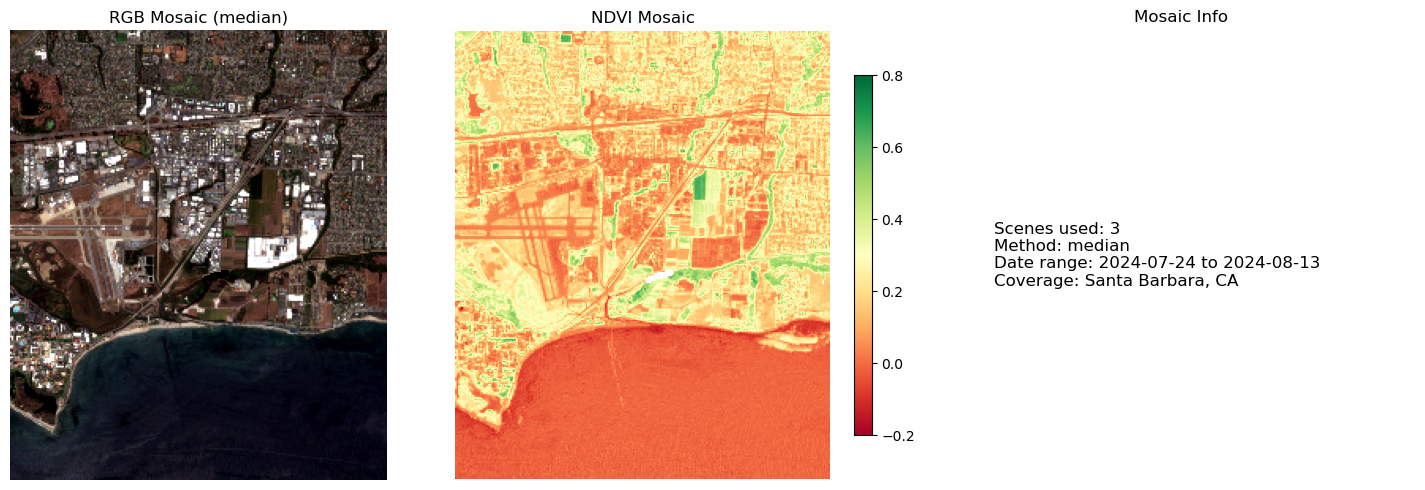

Temporal mosaic visualization complete


In [20]:
# Create median composite
mosaic = create_temporal_mosaic(processed_scenes, method='median')

if mosaic:
    # Visualize the mosaic
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # RGB composite of mosaic
    red_norm = normalize_for_display(mosaic['red'].values)
    green_norm = normalize_for_display(mosaic['green'].values)
    blue_norm = normalize_for_display(mosaic['blue'].values)
    rgb_mosaic = np.dstack([red_norm, green_norm, blue_norm])

    axes[0].imshow(rgb_mosaic)
    axes[0].set_title(f'RGB Mosaic ({mosaic.attrs["method"]})')
    axes[0].axis('off')

    # NDVI mosaic
    nir_vals = mosaic['nir'].values
    red_vals = mosaic['red'].values
    ndvi_mosaic = (nir_vals - red_vals) / (nir_vals + red_vals + 1e-8)

    ndvi_plot = axes[1].imshow(ndvi_mosaic, cmap='RdYlGn', vmin=-0.2, vmax=0.8)
    axes[1].set_title('NDVI Mosaic')
    axes[1].axis('off')
    plt.colorbar(ndvi_plot, ax=axes[1], shrink=0.8)

    # Data availability
    axes[2].text(0.1, 0.5, f"Scenes used: {mosaic.attrs['n_scenes']}\n"
                           f"Method: {mosaic.attrs['method']}\n"
                           f"Date range: {mosaic.attrs['date_range']}\n"
                           f"Coverage: Santa Barbara, CA",
                transform=axes[2].transAxes, fontsize=12, verticalalignment='center')
    axes[2].set_title('Mosaic Info')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

    print("Temporal mosaic visualization complete")

In [21]:
# Build the data cube
datacube = build_temporal_datacube(processed_scenes)

if datacube:
    print(f"\nData Cube Summary:")
    print(datacube)

2025-10-16 21:24:44,710 - INFO - Data cube created: (3, 284, 238), 3 time steps



Data Cube Summary:
<xarray.Dataset>
Dimensions:  (time: 3, y: 284, x: 238)
Coordinates:
  * time     (time) datetime64[ns] 2024-07-24 2024-08-03 2024-08-13
Dimensions without coordinates: y, x
Data variables:
    red      (time, y, x) float64 dask.array<chunksize=(1, 284, 238), meta=np.ndarray>
    green    (time, y, x) float64 dask.array<chunksize=(1, 284, 238), meta=np.ndarray>
    blue     (time, y, x) float64 dask.array<chunksize=(1, 284, 238), meta=np.ndarray>
    nir      (time, y, x) float64 dask.array<chunksize=(1, 284, 238), meta=np.ndarray>
    ndvi     (time, y, x) float64 dask.array<chunksize=(1, 284, 238), meta=np.ndarray>
    evi      (time, y, x) float64 dask.array<chunksize=(1, 284, 238), meta=np.ndarray>
Attributes:
    title:        Sentinel-2 Analysis-Ready Data Cube
    description:  Cloud-masked, reprojected temporal stack
    n_scenes:     3
    time_range:   2024-07-24 to 2024-08-13
    crs:          Unknown
    resolution:   Variable (depends on original scene 

Using spatial dimensions: y=142, x=119


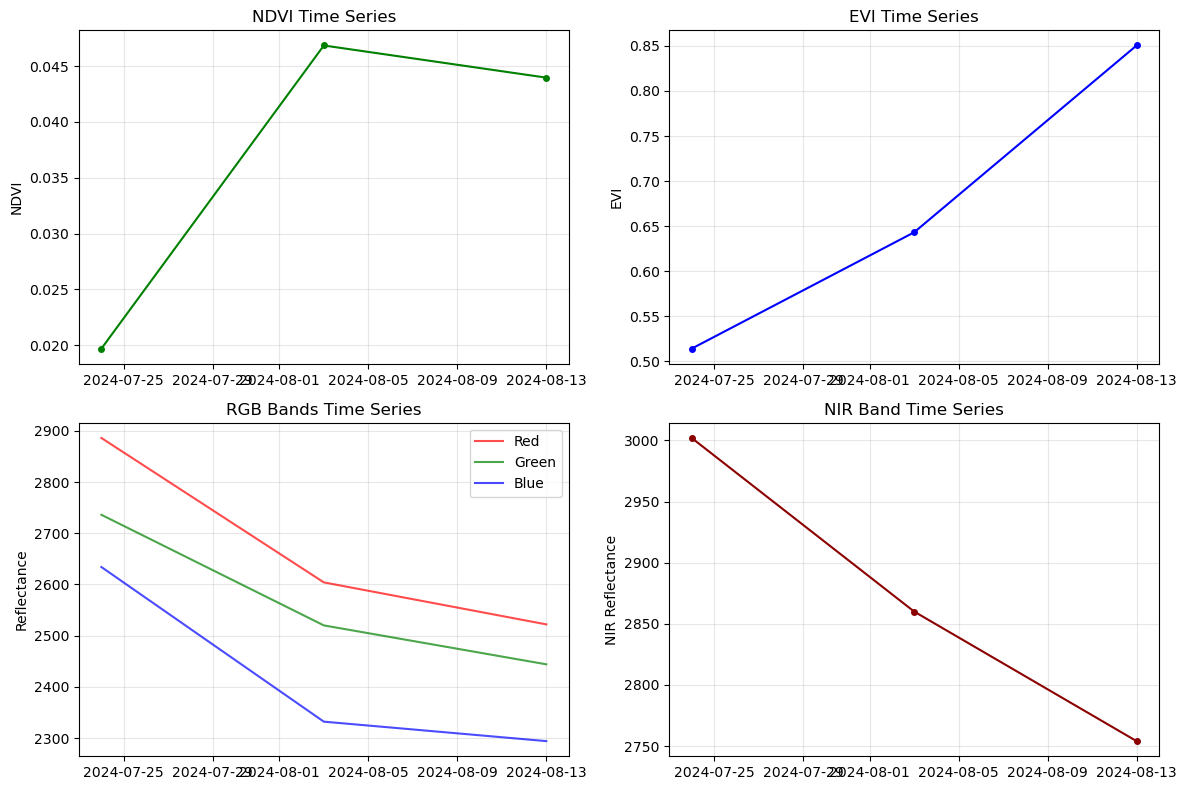

Time series analysis complete
Sample location indices: y=142, x=119


In [22]:
if datacube:
    # Extract time series for a sample location
    # Use more robust center selection - assume the spatial dims are the last two
    spatial_dims = [dim for dim in datacube['red'].dims if dim != 'time']
    if len(spatial_dims) >= 2:
        y_dim, x_dim = spatial_dims[0], spatial_dims[1]
        center_y_idx = datacube.dims[y_dim] // 2
        center_x_idx = datacube.dims[x_dim] // 2
        # Extract time series at center point using integer indexing
        point_ts = datacube.isel({y_dim: center_y_idx, x_dim: center_x_idx})
        print(f"Using spatial dimensions: {y_dim}={center_y_idx}, {x_dim}={center_x_idx}")
    else:
        print("Cannot determine spatial dimensions for time series analysis")
        point_ts = None

    # Create time series plots only if we have valid point data
    if point_ts is not None:
        fig, axes = plt.subplots(2, 2, figsize=(12, 8))

        # NDVI time series
        axes[0,0].plot(point_ts.time, point_ts['ndvi'], 'g-o', markersize=4)
        axes[0,0].set_title('NDVI Time Series')
        axes[0,0].set_ylabel('NDVI')
        axes[0,0].grid(True, alpha=0.3)

        # EVI time series
        axes[0,1].plot(point_ts.time, point_ts['evi'], 'b-o', markersize=4)
        axes[0,1].set_title('EVI Time Series')
        axes[0,1].set_ylabel('EVI')
        axes[0,1].grid(True, alpha=0.3)

        # RGB bands time series
        axes[1,0].plot(point_ts.time, point_ts['red'], 'r-', label='Red', alpha=0.7)
        axes[1,0].plot(point_ts.time, point_ts['green'], 'g-', label='Green', alpha=0.7)
        axes[1,0].plot(point_ts.time, point_ts['blue'], 'b-', label='Blue', alpha=0.7)
        axes[1,0].set_title('RGB Bands Time Series')
        axes[1,0].set_ylabel('Reflectance')
        axes[1,0].legend()
        axes[1,0].grid(True, alpha=0.3)

        # NIR time series
        axes[1,1].plot(point_ts.time, point_ts['nir'], 'darkred', marker='o', markersize=4)
        axes[1,1].set_title('NIR Band Time Series')
        axes[1,1].set_ylabel('NIR Reflectance')
        axes[1,1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        print("Time series analysis complete")
        print(f"Sample location indices: y={center_y_idx}, x={center_x_idx}")
    else:
        print("Skipping time series plots due to dimension issues")

In [23]:
# Initialize preprocessor
preprocessor = Sentinel2Preprocessor(
    output_dir="week2_preprocessed",
    target_crs='EPSG:32611',  # UTM Zone 11N for Santa Barbara
    target_resolution=20
)

print("Preprocessing pipeline ready")

2025-10-16 21:25:04,001 - INFO - Using anonymous access (basic rate limits)


Preprocessing pipeline ready


In [24]:
# Define workflow parameters - use tiny subset for fast demo
tiny_demo_subset = [-119.85, 34.40, -119.80, 34.45]  # Same 5km × 5km area as previous demos

workflow_params = {
    'bbox': tiny_demo_subset,  # Use small subset for speed
    'start_date': "2024-07-01",
    'end_date': "2024-08-15",
    'max_scenes': 3  # Process just 2-3 scenes for fast demo
}

print(f"Starting preprocessing workflow...")
print(f"  Area: ~5km × 5km subset near UCSB")
print(f"  Period: {workflow_params['start_date']} to {workflow_params['end_date']}")
print(f"  Note: Using small subset for fast demonstration")

# Search for scenes
workflow_items = preprocessor.search_scenes(
    workflow_params['bbox'],
    workflow_params['start_date'],
    workflow_params['end_date'],
    limit=workflow_params['max_scenes']
)

# Process scenes - limit to 2 for even faster execution
processed_data = []
for item in workflow_items[:2]:  # Process just 2 for fast demo
    result = preprocessor.process_scene(item, save_individual=True, subset_bbox=tiny_demo_subset)
    if result:
        processed_data.append(result)

# Create data cube
if processed_data:
    datacube = preprocessor.create_time_series_cube(processed_data, cube_name="demo_datacube")
    if datacube:
        print(f"\nWorkflow completed successfully!")
        print(f"  Time steps: {len(datacube.time)}")
        print(f"  Data cube shape: {datacube['red'].shape}")
        print(f"  Variables: {list(datacube.data_vars)}")

2025-10-16 21:25:11,350 - INFO - Using anonymous access (basic rate limits)


Starting preprocessing workflow...
  Area: ~5km × 5km subset near UCSB
  Period: 2024-07-01 to 2024-08-15
  Note: Using small subset for fast demonstration


2025-10-16 21:25:12,746 - INFO - Found 6 Sentinel-2 scenes (cloud cover < 15%)
2025-10-16 21:25:12,748 - INFO - Found 6 scenes
2025-10-16 21:25:15,274 - INFO - Successfully loaded 5 bands: ['B04', 'B03', 'B02', 'B08', 'SCL']
2025-10-16 21:25:20,733 - INFO - Successfully loaded 5 bands: ['B04', 'B03', 'B02', 'B08', 'SCL']
2025-10-16 21:25:20,868 - INFO - Data cube saved: week2_preprocessed/demo_datacube.nc



Workflow completed successfully!
  Time steps: 2
  Data cube shape: (2, 284, 238)
  Variables: ['red', 'green', 'blue', 'nir', 'ndvi']


In [25]:
# Generate processing summary
output_files = list(preprocessor.output_dir.glob("*.nc"))

print(f"\nProcessing Summary Report")
print(f"=" * 50)
print(f"Output Directory: {preprocessor.output_dir}")
print(f"Total Files Created: {len(output_files)}")
print(f"Processing Parameters:")
print(f"  - Target CRS: {preprocessor.target_crs}")
print(f"  - Target Resolution: {preprocessor.target_resolution}m")
print(f"  - Max Cloud Cover: {preprocessor.max_cloud_cover}%")

print(f"\nOutput Files:")
for file_path in sorted(output_files):
    file_size = file_path.stat().st_size / (1024*1024)  # MB
    print(f"  {file_path.name} ({file_size:.1f} MB)")

print(f"\nReady for Week 3: Machine Learning on Remote Sensing!")


Processing Summary Report
Output Directory: week2_preprocessed
Total Files Created: 3
Processing Parameters:
  - Target CRS: EPSG:32611
  - Target Resolution: 20m
  - Max Cloud Cover: 15%

Output Files:
  S2B_MSIL2A_20240803T183919_R070_T11SKU_20240803T220139_processed.nc (2.2 MB)
  S2B_MSIL2A_20240813T183919_R070_T11SKU_20240813T224159_processed.nc (2.2 MB)
  demo_datacube.nc (5.2 MB)

Ready for Week 3: Machine Learning on Remote Sensing!
